## Scrubber Discharge Project
Exploring the output files generated by the Salish Sea Atlantis Model
for Scrubber Discharge Project - preliminary runs (updated March 2023)

- scenario 1: 1-year discharge for Jan 2019 - Dec 2019
- scenario 2: 5-year discharge for Jan 2019 - Dec 2024
- scenario 3: 10-year discharge for Jan 2019 - Dec 2029

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
import ssam_plot as splot
from ssam_groups import cohorts

### Define scenario and control files

In [2]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/')
scenario_paths = sorted([p for p in scenario_root.glob('v6699_discharge_100y_20*/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [3]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/v6699_discharge_100y_control/outputSalishSea.nc"
control      = xr.open_dataset(str(control_file), decode_cf=True)
ds_time = np.ma.filled(control.variables['t'], np.nan)

In [32]:
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)

scenario2019_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/v6699_discharge_100y_2019/outputSalishSea.nc"
scenario2024_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/v6699_discharge_100y_2024/outputSalishSea.nc"
scenario2029_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Scrubber/v6699_discharge_100y_2029/outputSalishSea.nc"

scenario2019 = xr.open_dataset(str(scenario2019_file), decode_cf=True)
scenario2024 = xr.open_dataset(str(scenario2024_file), decode_cf=True)
scenario2029 = xr.open_dataset(str(scenario2029_file), decode_cf=True)

ds_time = np.ma.filled(scenario2019.variables['t'], np.nan)

annual_control = control.resample(t='5Y').mean()

annual_scenario2019 = scenario2019.resample(t='5Y').mean()
annual_scenario2024 = scenario2024.resample(t='5Y').mean()
annual_scenario2029 = scenario2029.resample(t='5Y').mean()

time = np.ma.filled(annual_control.variables['t'], np.nan)

annual_scenarios = [annual_scenario2019, annual_scenario2024, annual_scenario2029]

In [4]:
#t_corrected = t - np.timedelta64(578, 'D')

start = 40 #40
end =  120 #ds_time.size-1 

event_start = np.datetime64('2019-01-01')

annual_end = time.size

scenarios = [scenario2019, scenario2024, scenario2029]

In [49]:
print(ds_time[52], ds_time[72], ds_time[92])

2019-12-11T14:00:00.000000000 2024-12-04T14:00:00.000000000 2029-11-28T14:00:00.000000000


In [50]:
days = [52, 72, 92]
data = {'Up to 2019-12': [], 'Up to 2024-12': [],'Up to 2029-12': []}

## Water column PAH concentrations due to discharge

Phenanthrene concentrations in each scenario

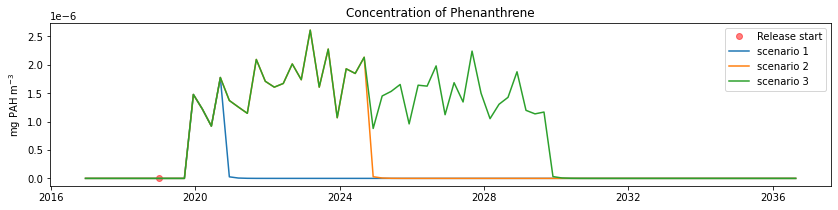

In [7]:
splot.compare_one_pah_concentration_across_scenarios('Phenanthrene', scenario_datasets, ds_time, start, 120, groups.salish_sea, event_start)

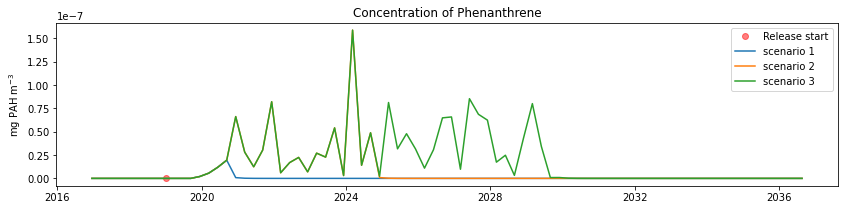

In [8]:
splot.compare_one_pah_concentration_across_scenarios('Phenanthrene', scenario_datasets, ds_time, start, 120, groups.sog_center, event_start)

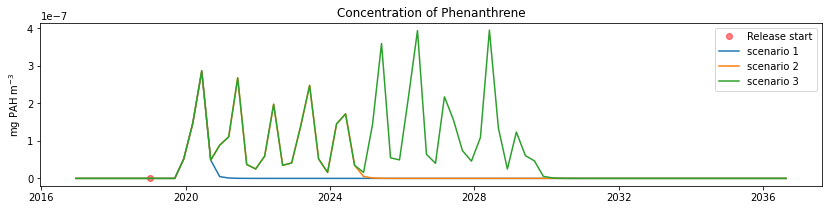

In [9]:
splot.compare_one_pah_concentration_across_scenarios('Phenanthrene', scenario_datasets, ds_time, start, 120, groups.juan_de_fuca, event_start)

## Biology PAH concentrations

### lower trophic levels

## Bioloigcal impacts

### lower trophic levels

Entire Salish Sea

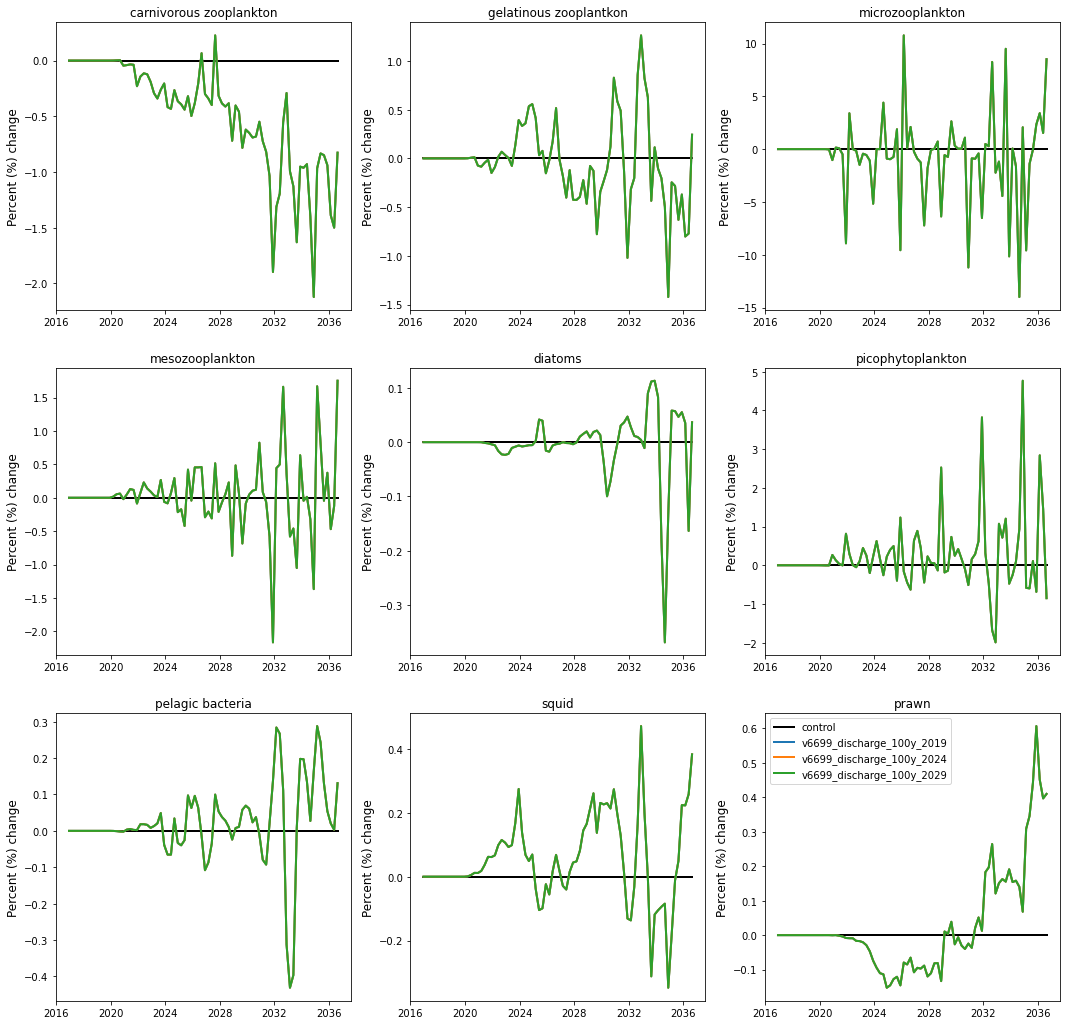

In [10]:
splot.compare_scenarios_pelagic_N(groups.planktonic, scenario_datasets, control, ds_time, start, end, groups.salish_sea, scenario_paths, y_min=None, y_max=None)

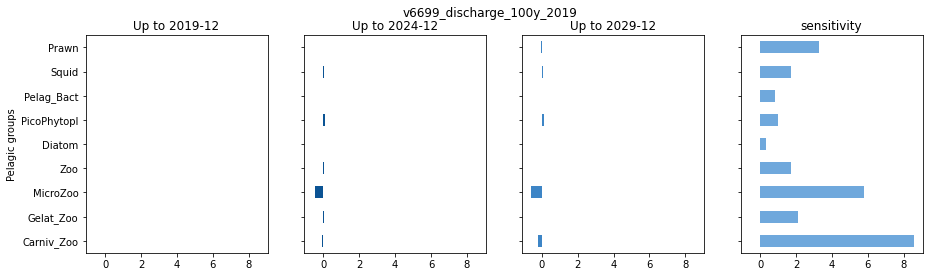

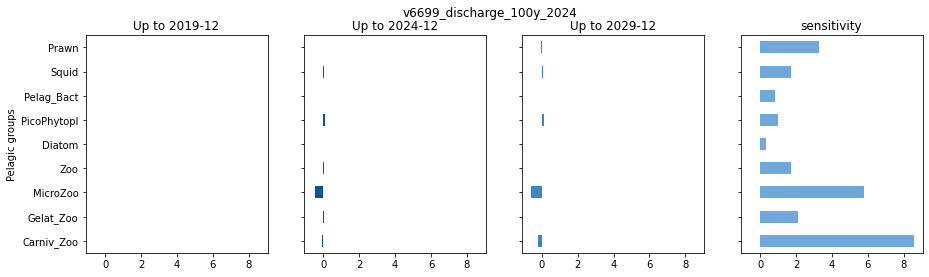

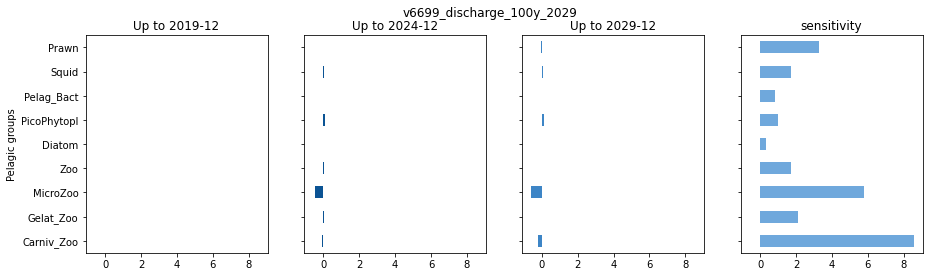

In [51]:
splot.boxplot_pelagic(groups.planktonic, scenario_datasets, control, start, days, groups.salish_sea, data, scenario_labels, x_lim=None)

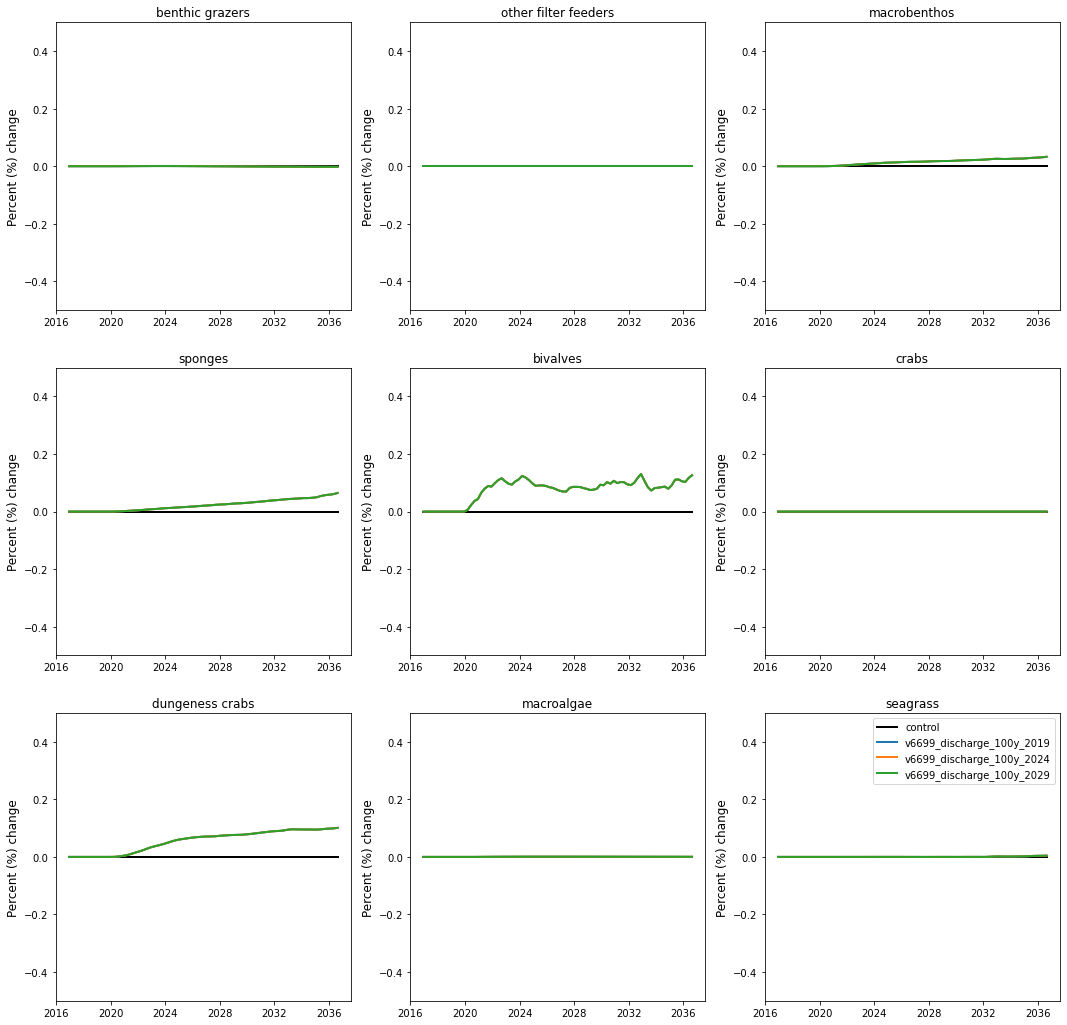

In [19]:
splot.compare_scenarios_benthic_N(groups.benthos, scenario_datasets, control, ds_time, start, end, groups.salish_sea, scenario_paths, y_min=-0.5, y_max=0.5)

Select regions

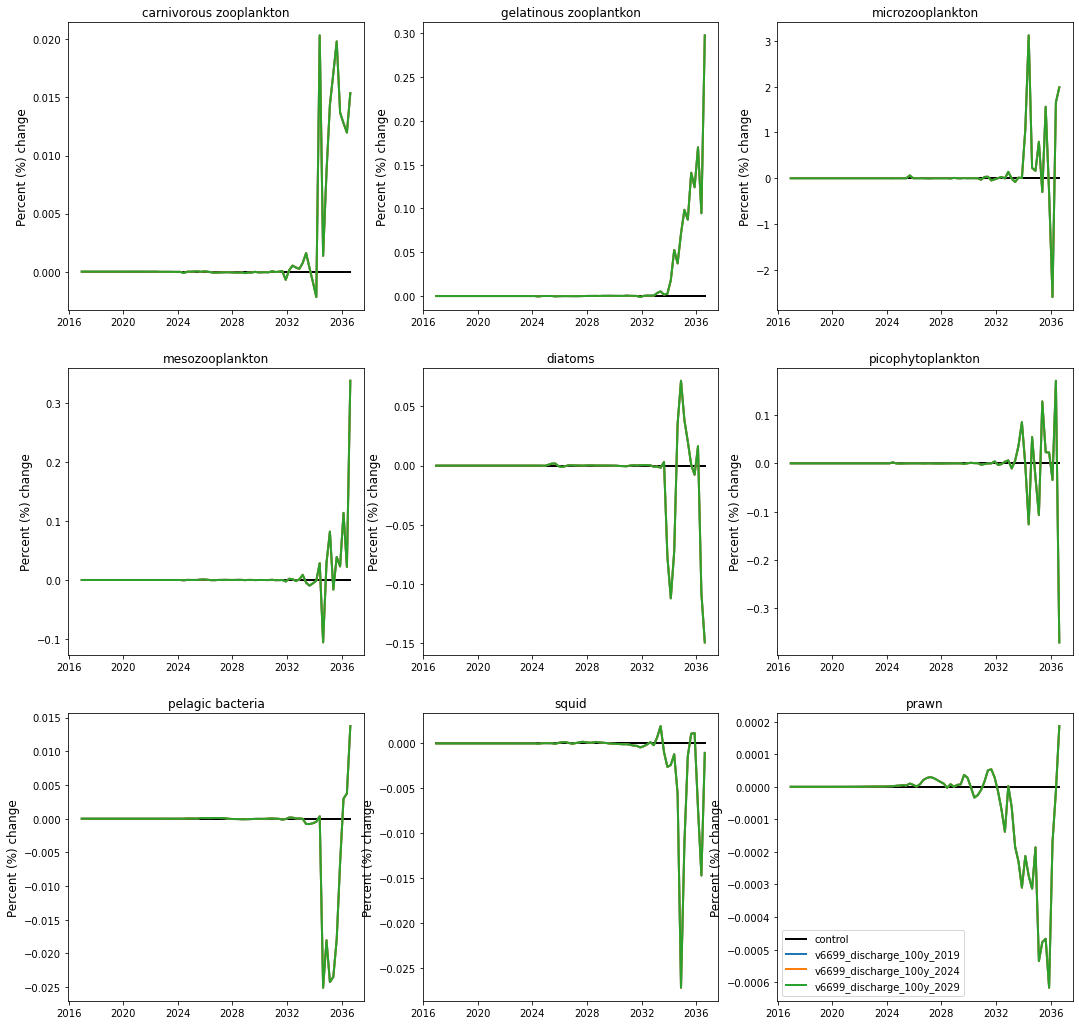

In [22]:
# Central Strait of Georgia
splot.compare_scenarios_pelagic_N(groups.planktonic, scenario_datasets, control, ds_time, start, end, groups.sog_center, scenario_paths, y_min=None, y_max=None)

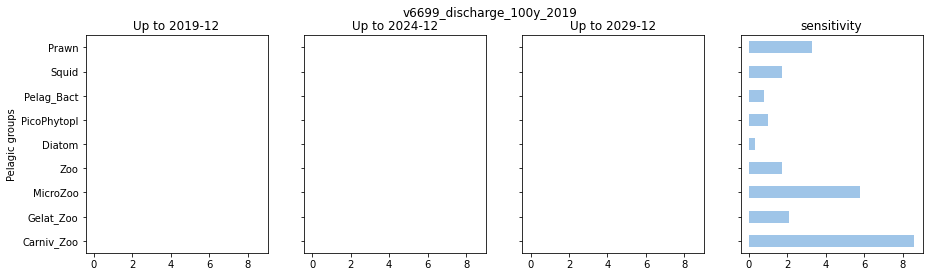

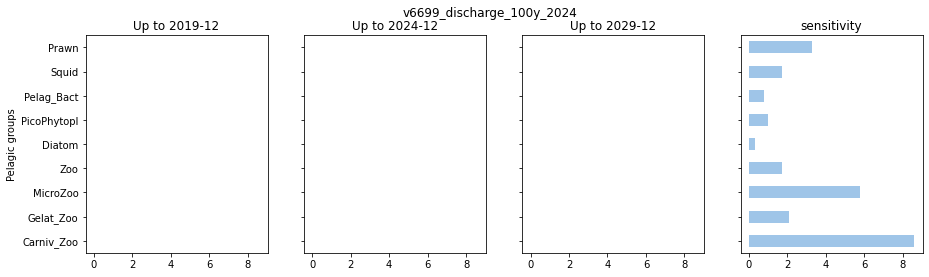

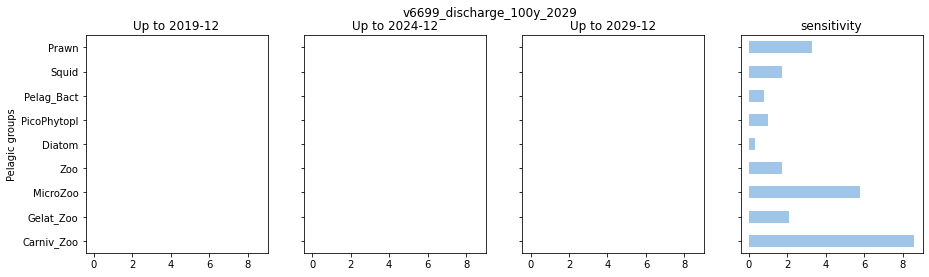

In [59]:
splot.boxplot_pelagic(groups.planktonic, scenario_datasets, control, start, days, groups.sog_center, data, scenario_labels, x_lim=None, bio_colours=['#063764','#0b5394','#3d85c6','#9fc5e8'])

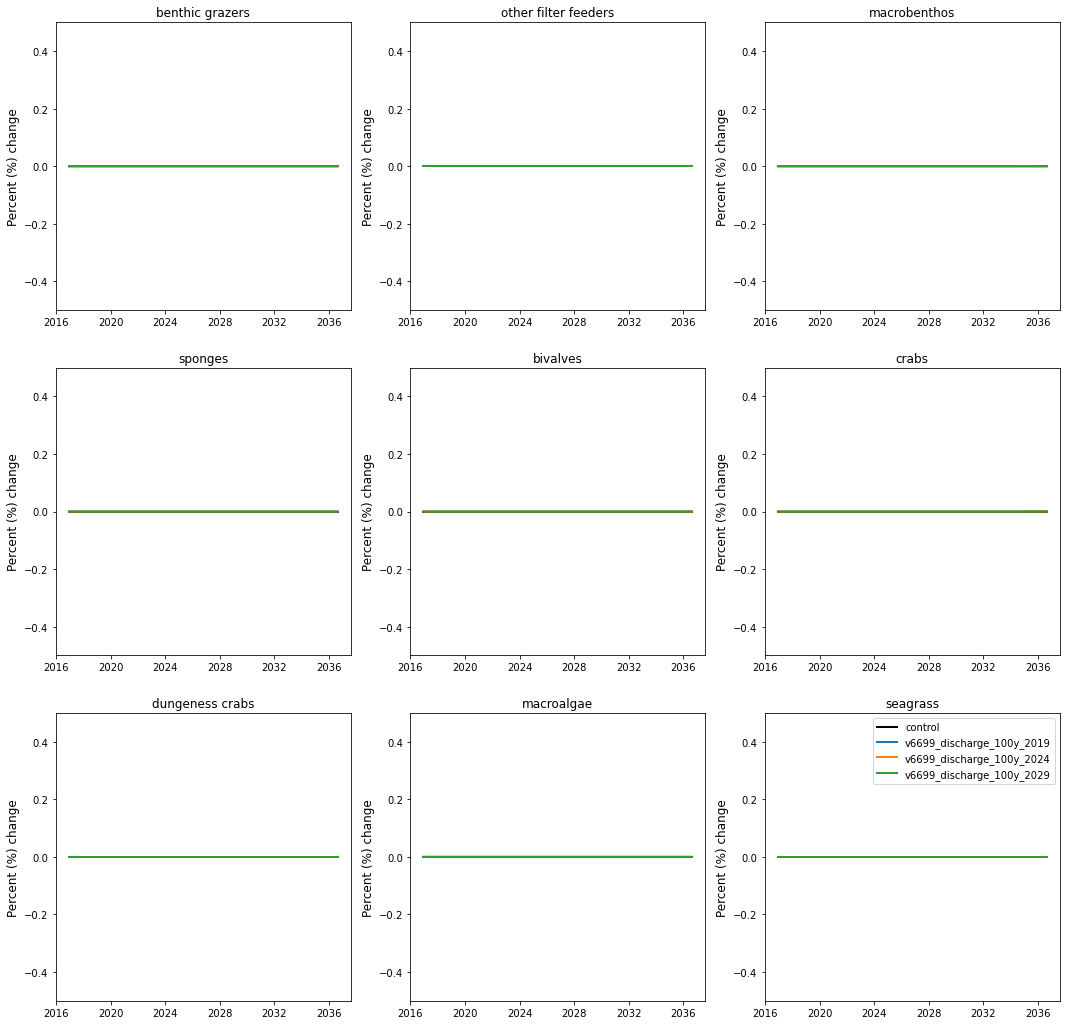

In [ ]:
# Central Strait of Georgia
splot.compare_scenarios_benthic_N(groups.benthos, scenario_datasets, control, ds_time, start, end, groups.sog_center, scenario_paths, y_min=-0.5, y_max=0.5)

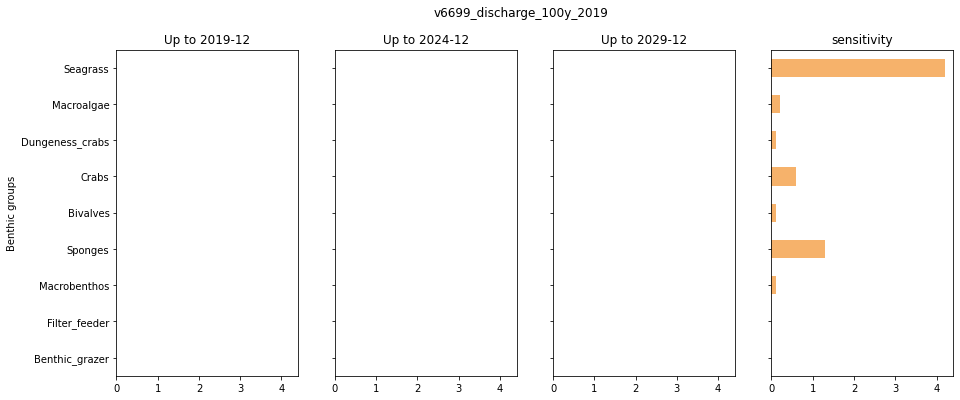

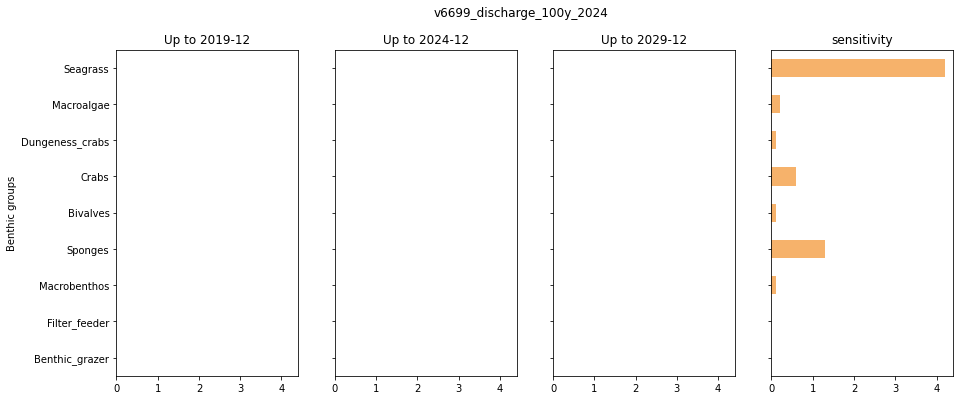

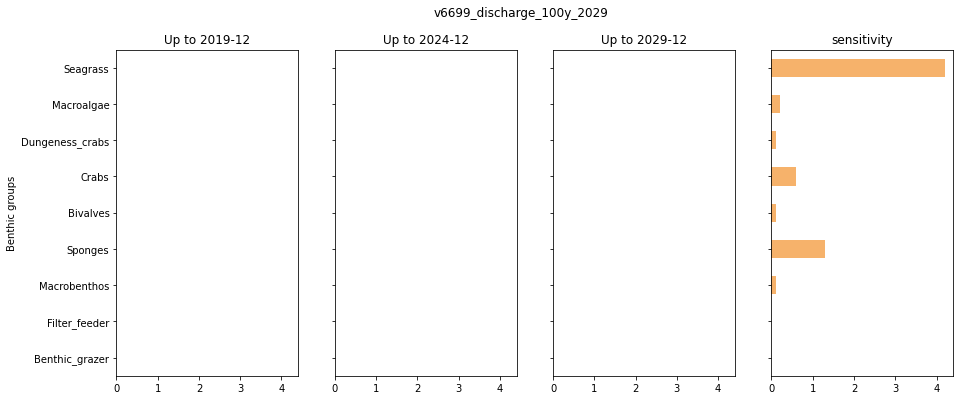

In [58]:
splot.boxplot_benthic(groups.benthos, scenario_datasets, control, start, days, groups.sog_center, data, scenario_labels, x_lim=None)

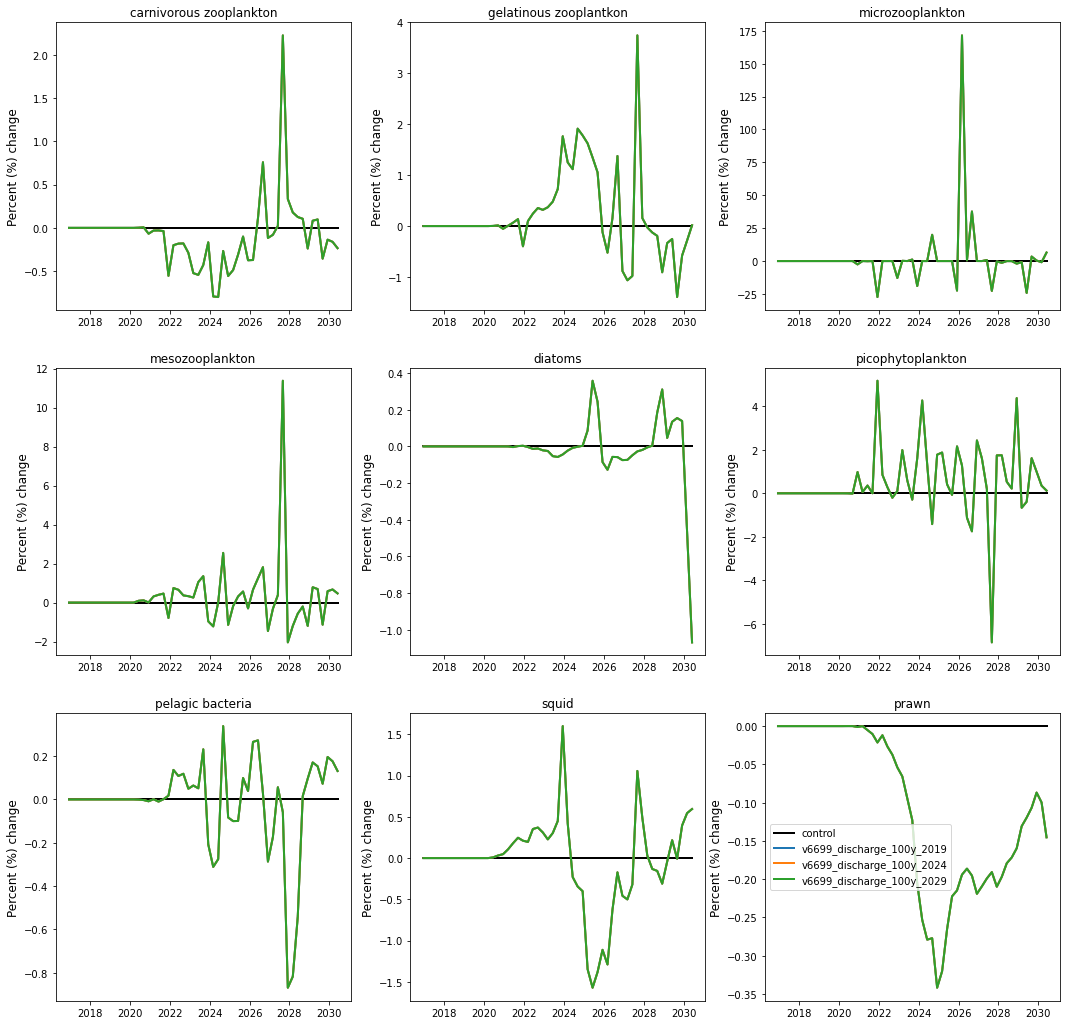

In [54]:
splot.compare_scenarios_pelagic_N(groups.planktonic, scenario_datasets, control, ds_time, start, 95, groups.juan_de_fuca, scenario_paths, y_min=None, y_max=None)

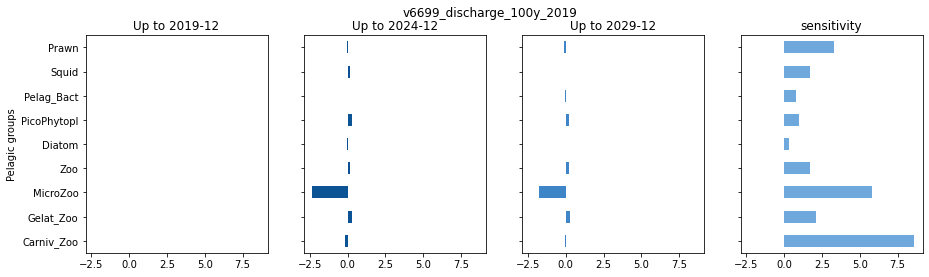

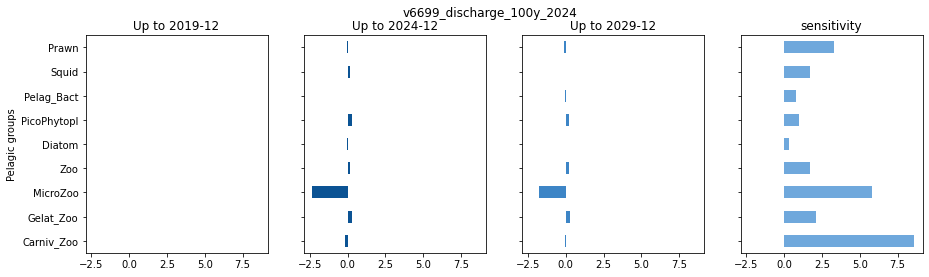

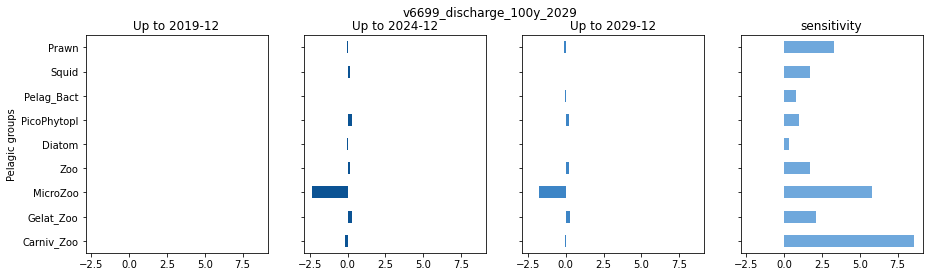

In [53]:
splot.boxplot_pelagic(groups.planktonic, scenario_datasets, control, start, days, groups.juan_de_fuca, data, scenario_labels, x_lim=None)

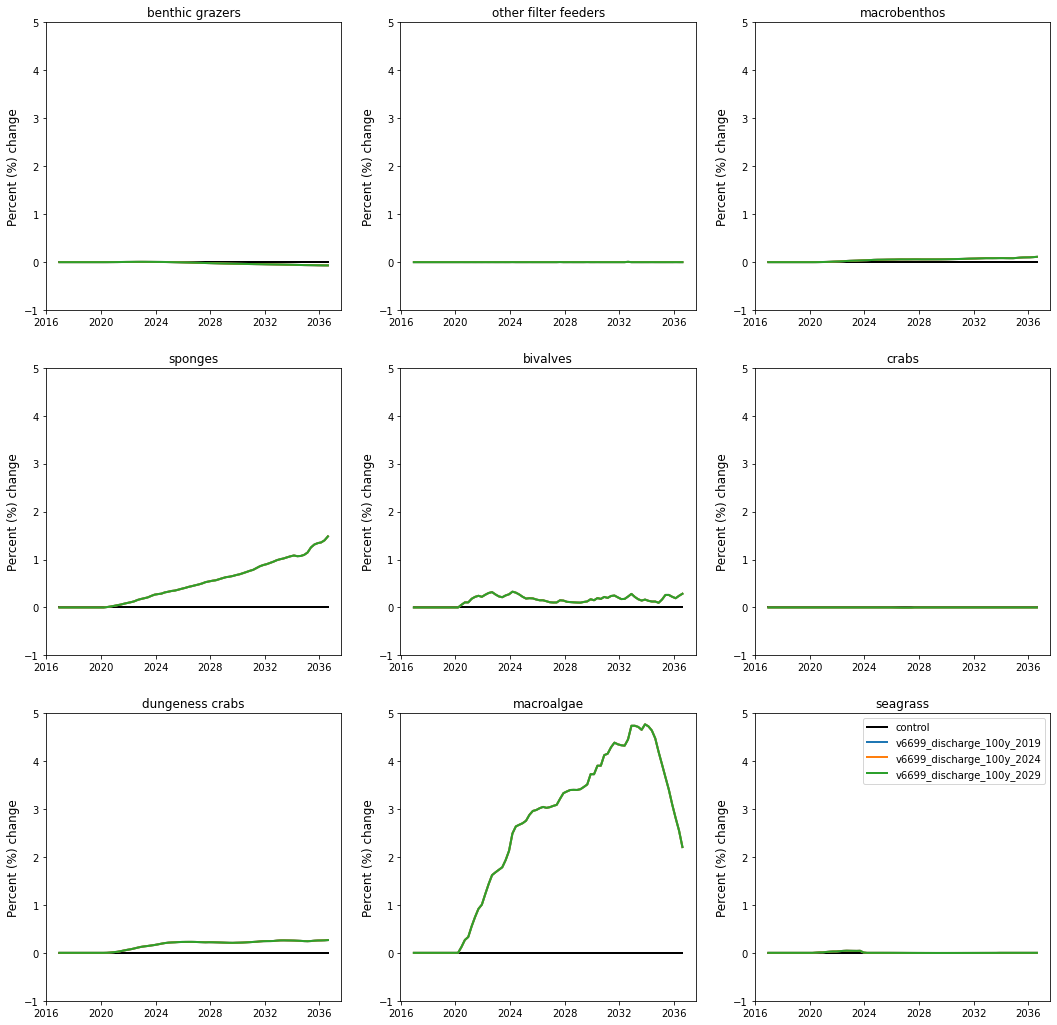

In [30]:
splot.compare_scenarios_benthic_N(groups.benthos, scenario_datasets, control, ds_time, start, end, groups.juan_de_fuca, scenario_paths, y_min=-1, y_max=5)

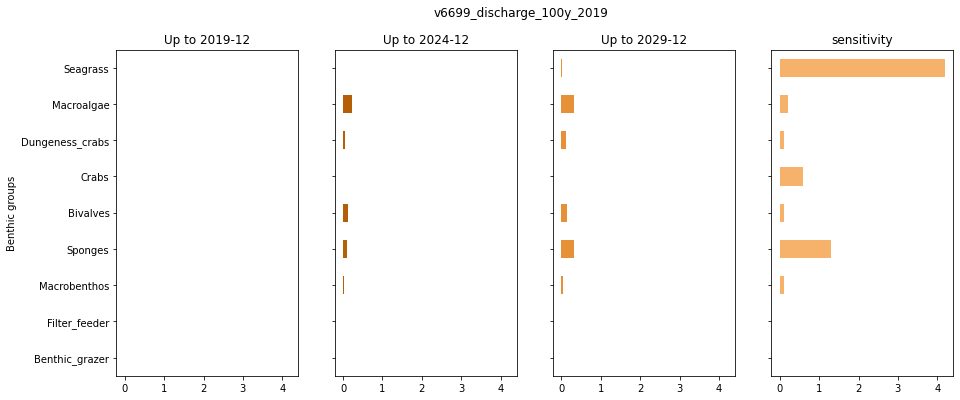

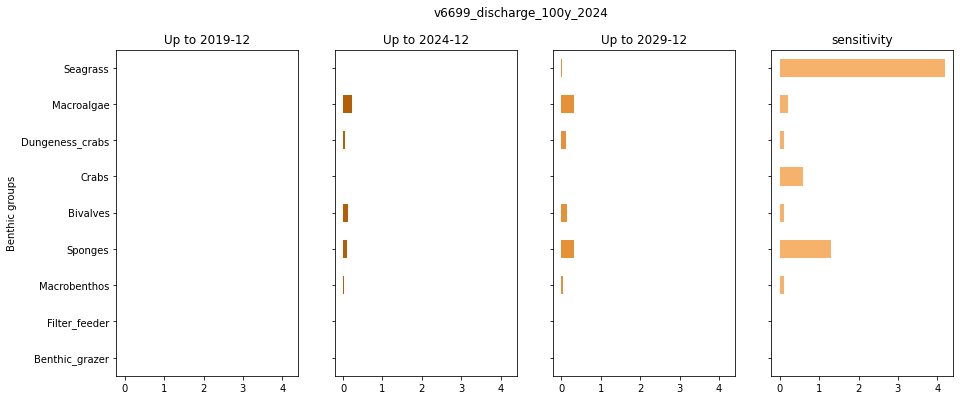

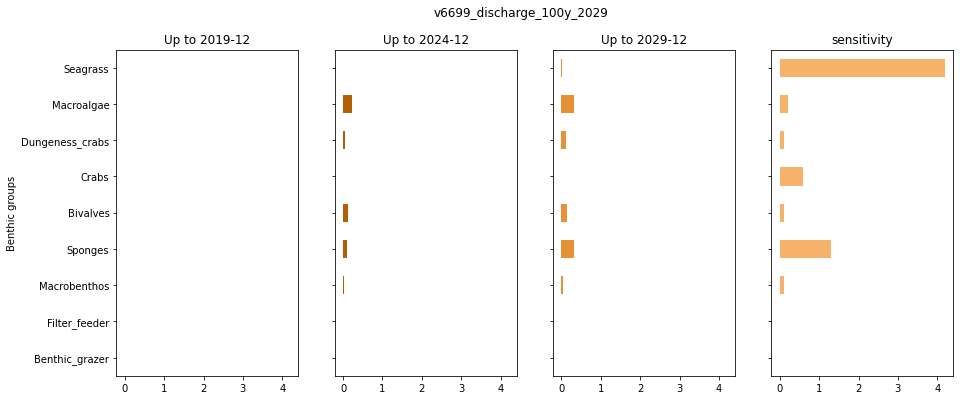

In [57]:
splot.boxplot_benthic(groups.benthos, scenario_datasets, control, start, days, groups.juan_de_fuca, data, scenario_labels, x_lim=None)

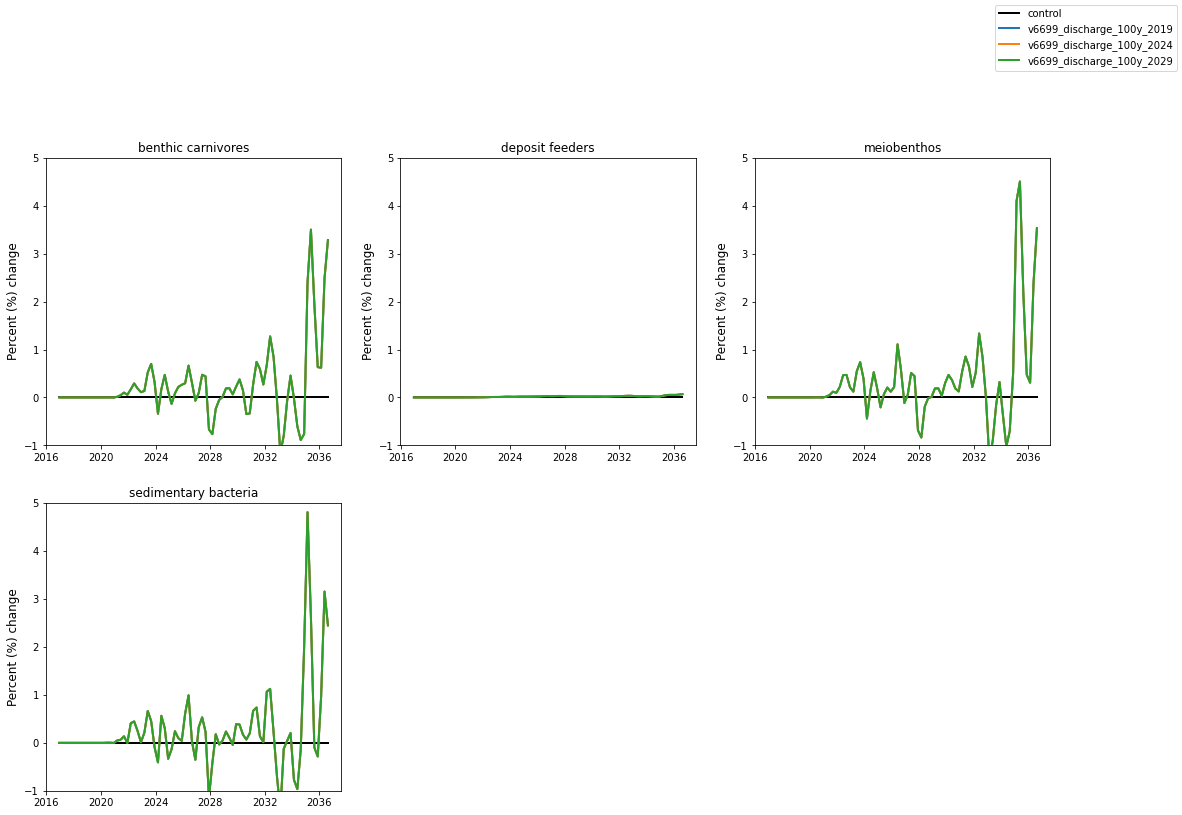

In [31]:
splot.compare_scenarios_sediment_N(groups.sediment_feeders, scenario_datasets, control, ds_time, start, end, groups.juan_de_fuca, scenario_paths, y_min=-1, y_max=5)


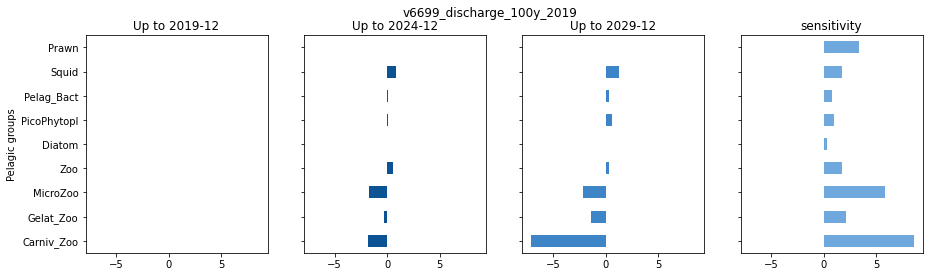

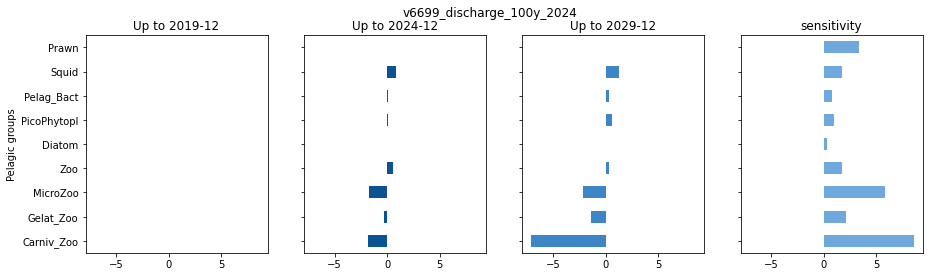

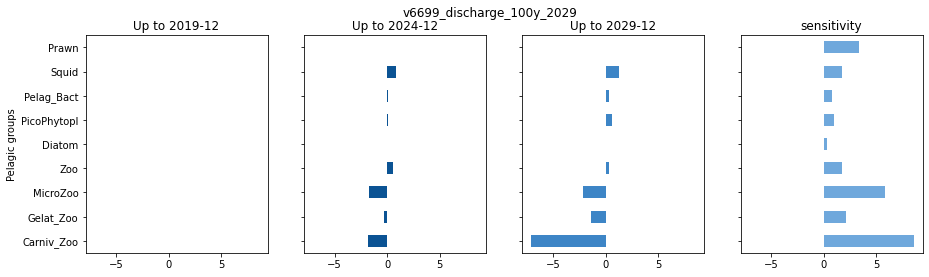

In [55]:
splot.boxplot_pelagic(groups.planktonic, scenario_datasets, control, start, days, groups.fraser_river, data, scenario_labels, x_lim=None)

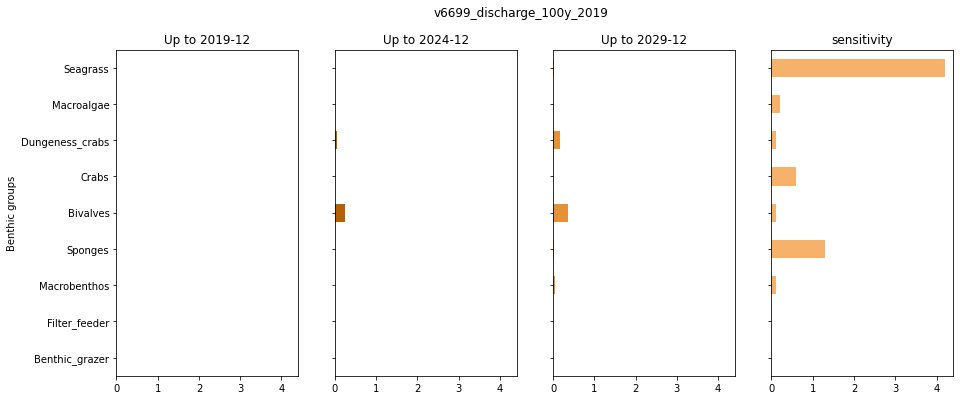

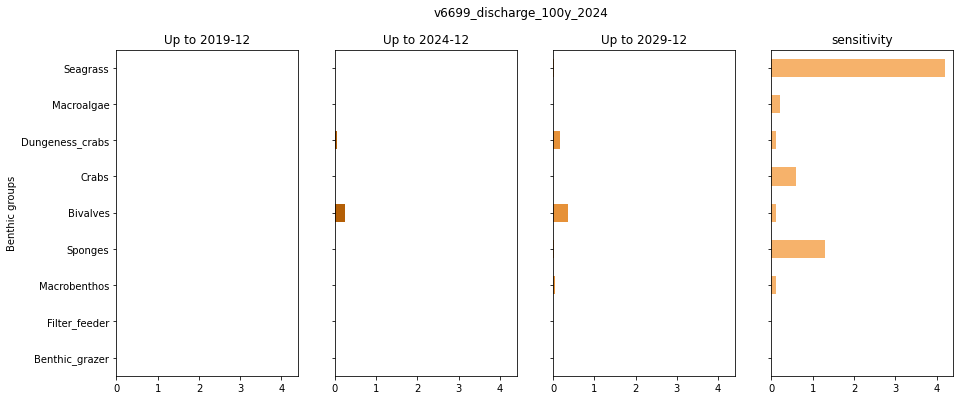

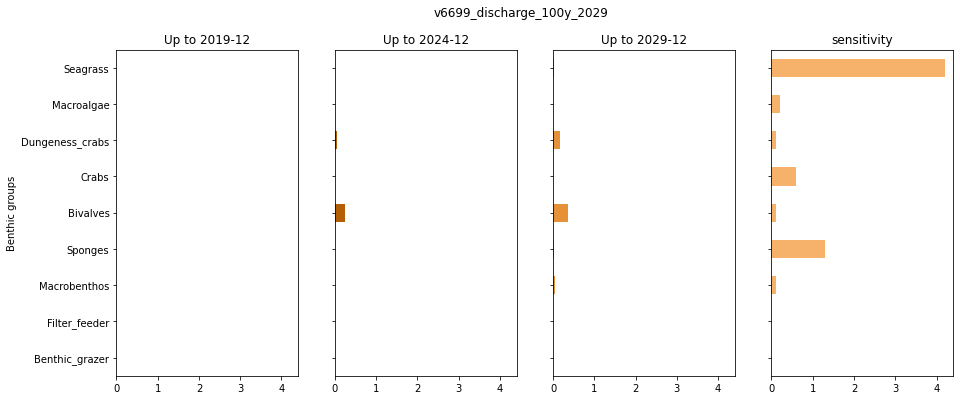

In [56]:
splot.boxplot_benthic(groups.benthos, scenario_datasets, control, start, days, groups.fraser_river, data, scenario_labels, x_lim=None)

## five-year averaged data

In [23]:
initial_year = [51,52,53,54,55]
fifth_year = [71,72,73,74,75]
tenth_year = [91,92,93,94,95]
#fiftieth_year = [252,253,254,255,256]

days = [initial_year, fifth_year, tenth_year] #, fiftieth_year]
data = {'initial time of discharge': [], '5 years later': [],'10 years later': []} #, '50 years later': []}

In [20]:
def avg_pelagic_boxplot_5(group):
    bio_colours=['#063764','#0b5394','#3d85c6','#6fa8dc','#9fc5e8']
    names = ['discharge 2019 only','discharge 2019-2024', 'discharge 2019-2029']
    cum_years = [3,4,5]
    for scenario, name in zip(annual_scenarios, names):
        df = pd.DataFrame(data)
        spp = []
        
        for species in group:
            results = list()
            for year in cum_years:
                p_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][year,:,0:5], np.nan) # tonnes, take only water column layers
                p_control = np.ma.filled(annual_control.variables[group[species] + '_N'][year,:,0:5], np.nan)
                p_oiled = p_oiled.sum(axis=0)
                p_oiled = p_oiled.sum(axis=0)
                p_control = p_control.sum(axis=0)
                p_control = p_control.sum(axis=0)
                ratio = (p_oiled/p_control-1)*100
                results.append(ratio)
            spp.append(group[species])
            df.loc[len(df.index)] = results
        df['bio_group'] = spp
        df1 = df.set_index('bio_group')

        df1.plot(kind="barh", subplots=True, layout=(1,len(days)), title=name, figsize=(15,4), sharey=True, sharex=True, color=bio_colours, legend=False, #ax=ax,
            xlabel='Pelagic Groups', ylabel=None, xlim=[-25,15]); 

In [14]:
names = ['discharge 2019 only','discharge 2019-2024', 'discharge 2019-2029']

5-year average, 1st year of discharge, exploring the planktonic species, which are the only one to respond within this timeframe

In [28]:
def average_depth_plot(group):
    for year in cum_years[0:2]:
        fig = plt.figure(figsize=(15, 15), facecolor='white', constrained_layout=True)
        gs = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1], figure=fig) 

        discharge_time = {0:'1st year of discharge', 1:'5 years later', 2:'10 years later', 3:'50 years later',}
        depth = [400, 250, 100, 50, 25, 0]

        for species in group:

            bio_index = (list(group).index(species))

            if bio_index < 4:
                position = 0, bio_index
            elif bio_index > 7: 
                position = 2, bio_index-8
            else :
                position = 1, bio_index-4

            ax = fig.add_subplot(gs[position])
            
            pelagic_control = np.ma.filled(annual_control.variables[group[species] + '_N'][year,:,0:6], np.nan)
            p_control = pelagic_control.sum(axis=0)
            ax.set_ylim(250, 0)  # decreasing depth
            
            for scenario in annual_scenarios:

                pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][year,:,0:6], np.nan) # tonnes, take only water column layers
                p_oiled = pelagic_oiled.sum(axis=0)
                ax.plot(p_oiled, depth, linewidth = 2)
            ax.plot(p_control, depth, '-.k', linewidth = 2, alpha=0.8)
            ax.set_title(species);
            ax.set_ylabel('depth (m)')
            ax.set_xlabel('5y average mg N m$^{-3}$')
        ax.legend(['1y discharge','5y discharge','10y discharge','control: no discharge'],bbox_to_anchor=(1.05, 1), loc='lower right');  # place the legend outside)
        fig.suptitle(discharge_time[cum_years.index(year)], fontsize=14)

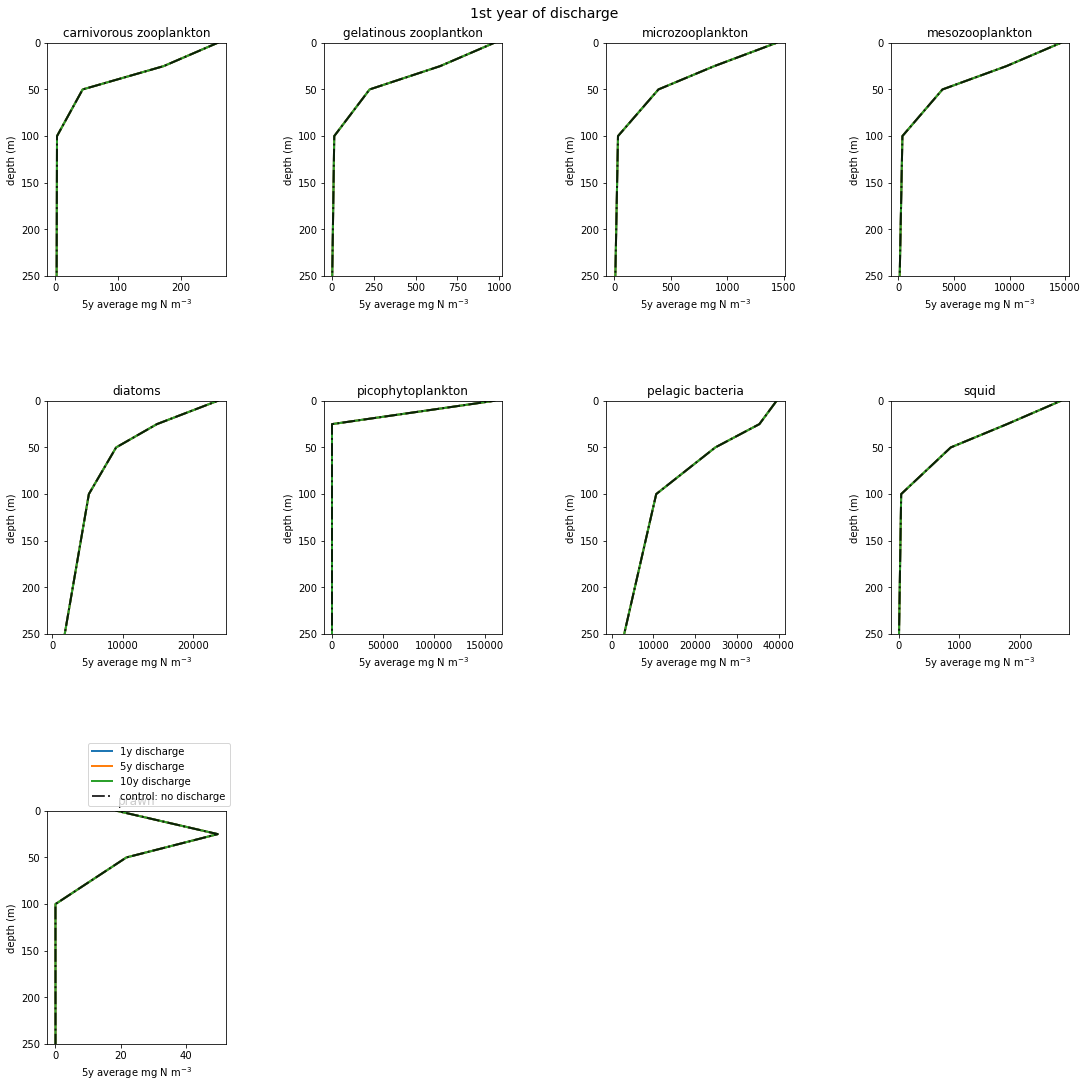

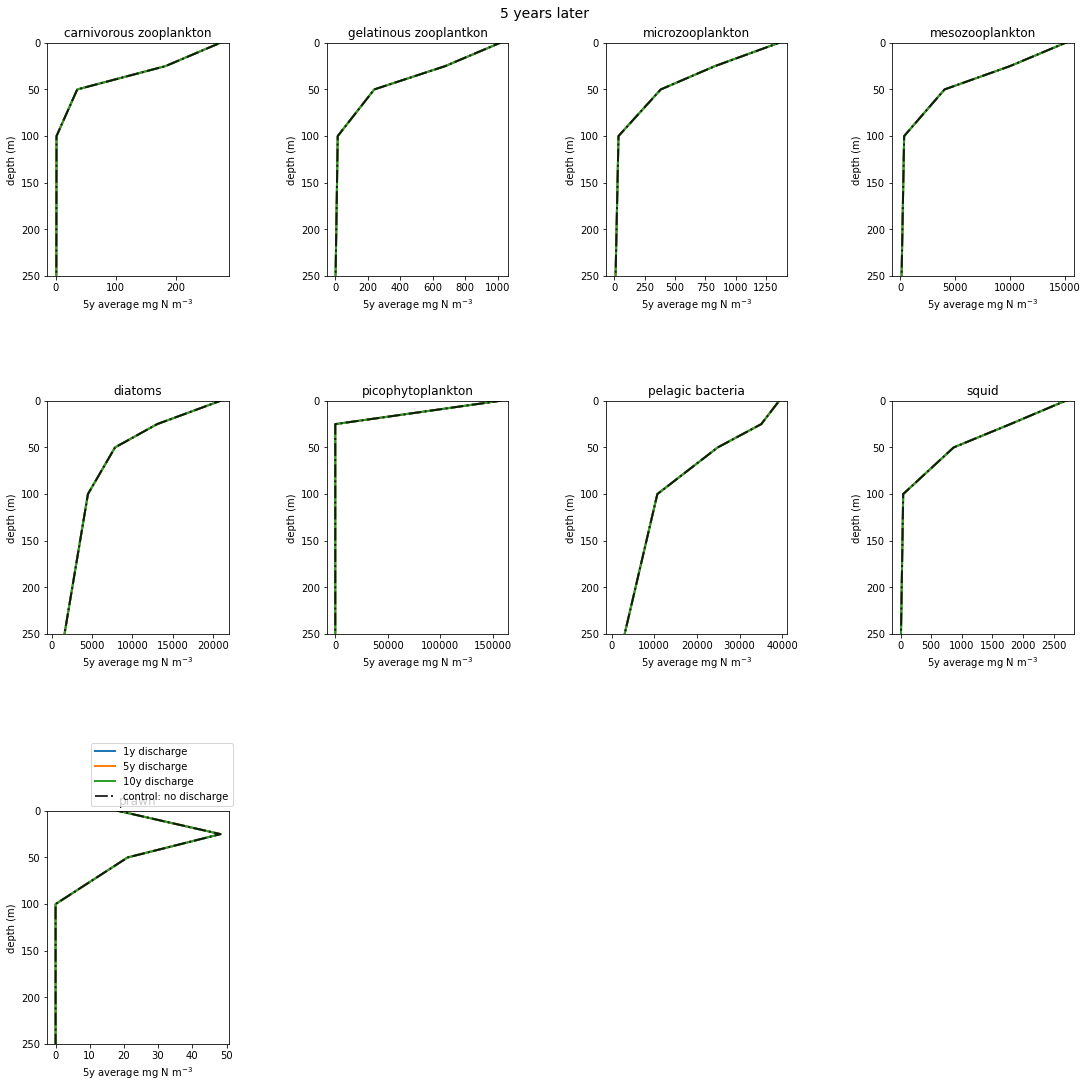

In [29]:
average_depth_plot(groups.planktonic)

### Regional difference?

In [30]:
#regions by Atlantis boxes
JdF_west = [1,2,3,4]
JdF_east = [5,6,7,8,9,10,11]
Haro_Boundary = [60,33,34,35,36]
SoG_south = [54,64,68,79]
SoG_center = [80,81,82,83,84,85]
SoG_north = [88,92.98,101,102]
PS_main = [20,21,23,26]

## Internal Phenanthrene concentrations

In [ ]:
tissue_concentration(groups.planktonic, annual_scenarios)

#### Functions

In [37]:
def tissue_concentration(group, scenarios):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scenarios: 
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_Phenanthrene'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH as Phe', fontsize=12)
        ax.set_title(species);
    fig.legend(['1yr discharge','5y discharge', '10yr discharge'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

In [36]:
def tissue_juveniles_concentration(group, scenarios):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scenarios:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '1_Phenanthrene'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH as Phe', fontsize=12)
        ax.set_title(species);
    fig.legend(['1yr discharge','5y discharge', '10yr discharge'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

In [35]:
def tissue_adults_concentration(group, scenarios):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario in scenarios:
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '5_Phenanthrene'][:,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time, pelagic_oiled, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH as Phe', fontsize=12)
        ax.set_title(species);
    fig.legend(['1yr discharge','5y discharge', '10yr discharge'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

In [34]:
def tissue_vertebrate_concentration(group, scenarios):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:

        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        numCohorts = cohorts[group[species]]

        oiled_cohort = np.zeros(len(time))

        for scenario in scenarios:
            for cohort in range (1, numCohorts+1):

                new_species = group[species] + str(cohort)
            
                oiled_species = np.ma.filled(scenario.variables[new_species + '_Phenanthrene'][:,:,:], np.nan)
                oiled_species = oiled_species.sum(axis=2)
                oiled_species = oiled_species.sum(axis=1)

                oiled_cohort = oiled_cohort + oiled_species
            ax.plot(time, oiled_cohort, linewidth = 2) #semilogy
        
        plt.ylabel('mg PAH as Phe', fontsize=12)
        ax.set_title(species);
    fig.legend(['1yr discharge','5y discharge', '10yr discharge'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12); 

#### Plots

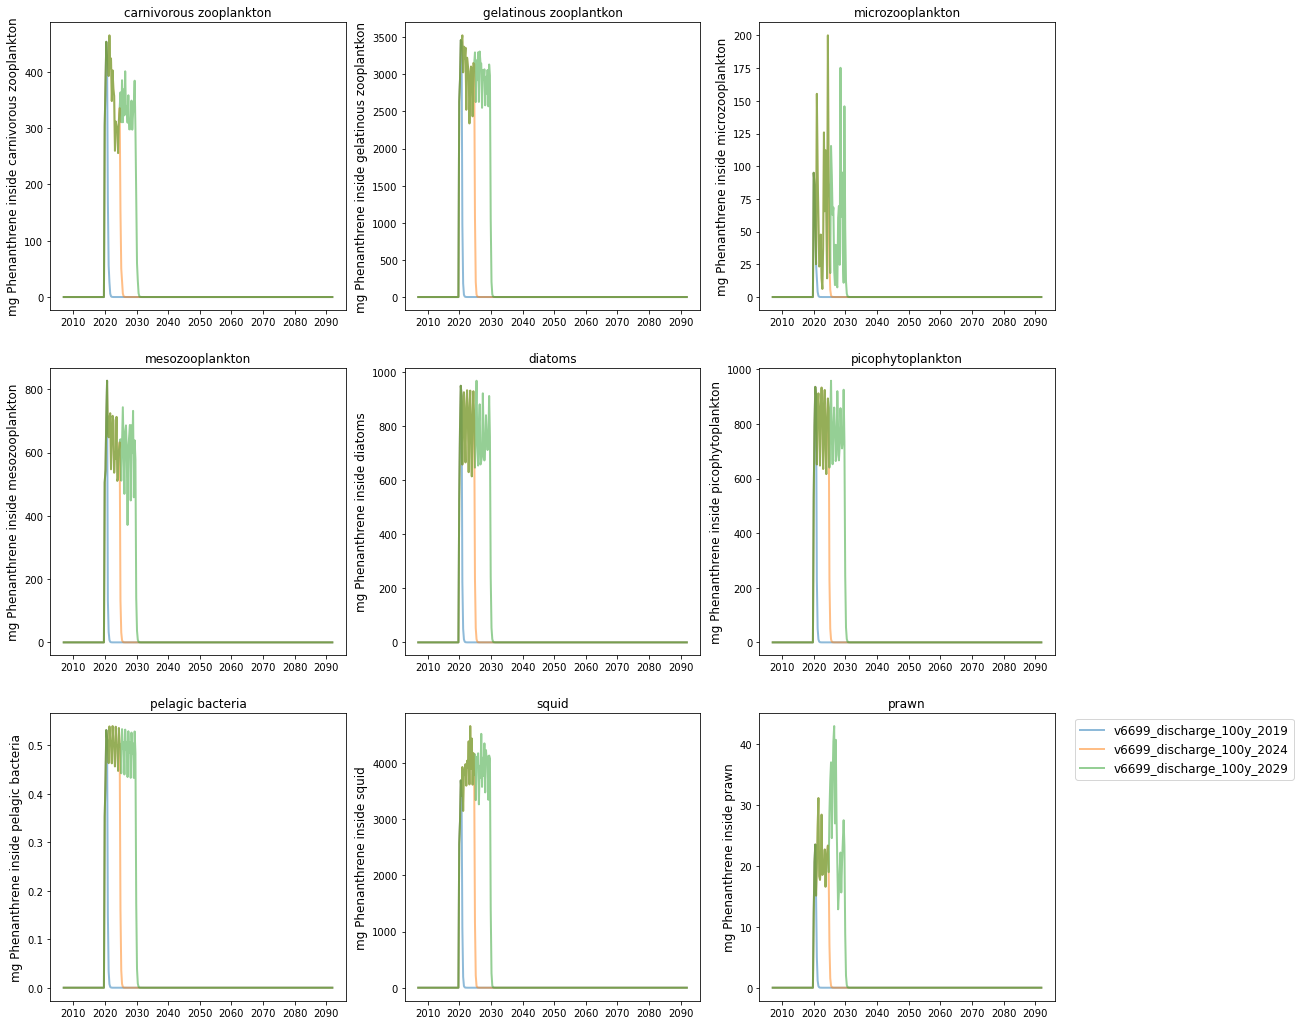

In [60]:
splot.compare_pah_mass_in_bio_tissue_across_scenarios(groups.planktonic, 'Phenanthrene', scenario_datasets, ds_time, groups.salish_sea, scenario_labels)

In [63]:
parameter_group = []
for group in groups.planktonic:
    parameter_group.append(groups.planktonic[group]+'_Phenanthrene')

In [64]:
parameter_group

['Carniv_Zoo_Phenanthrene',
 'Gelat_Zoo_Phenanthrene',
 'MicroZoo_Phenanthrene',
 'Zoo_Phenanthrene',
 'Diatom_Phenanthrene',
 'PicoPhytopl_Phenanthrene',
 'Pelag_Bact_Phenanthrene',
 'Squid_Phenanthrene',
 'Prawn_Phenanthrene']

In [ ]:
splot.compare_scenarios_pelagic_parameter(parameter_group, scenarios, control, time, start, end, boxes, y_min=None, y_max=None): # for use with any parameter that does not require _N

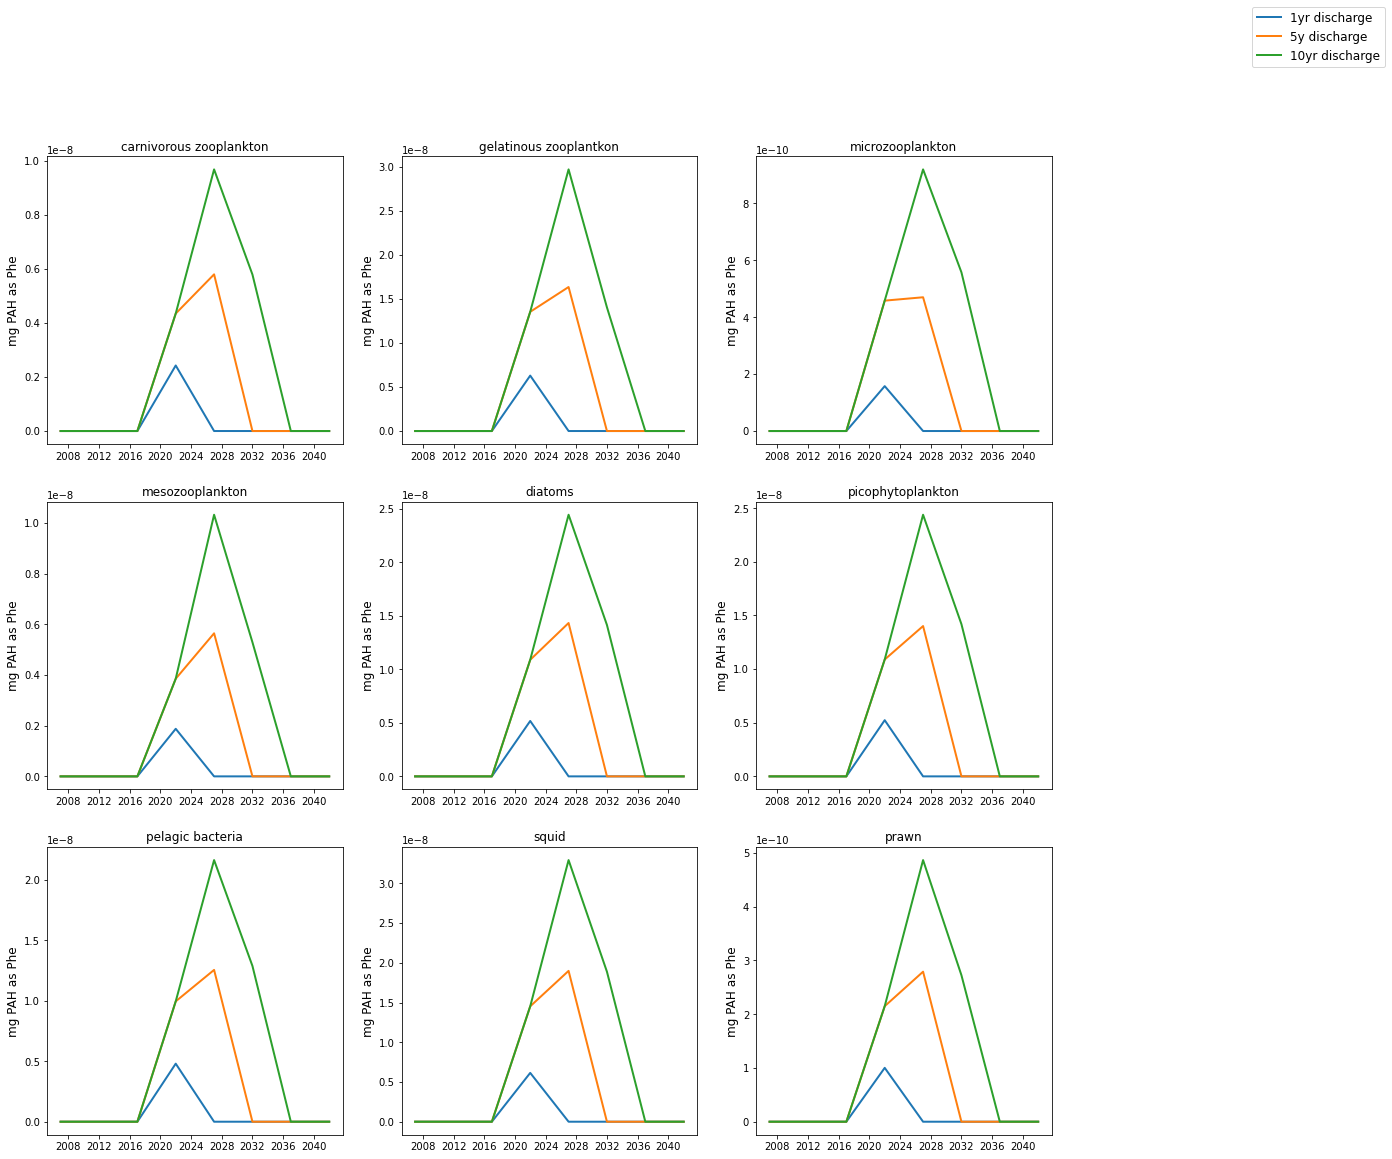

In [38]:
tissue_concentration(groups.planktonic, annual_scenarios)

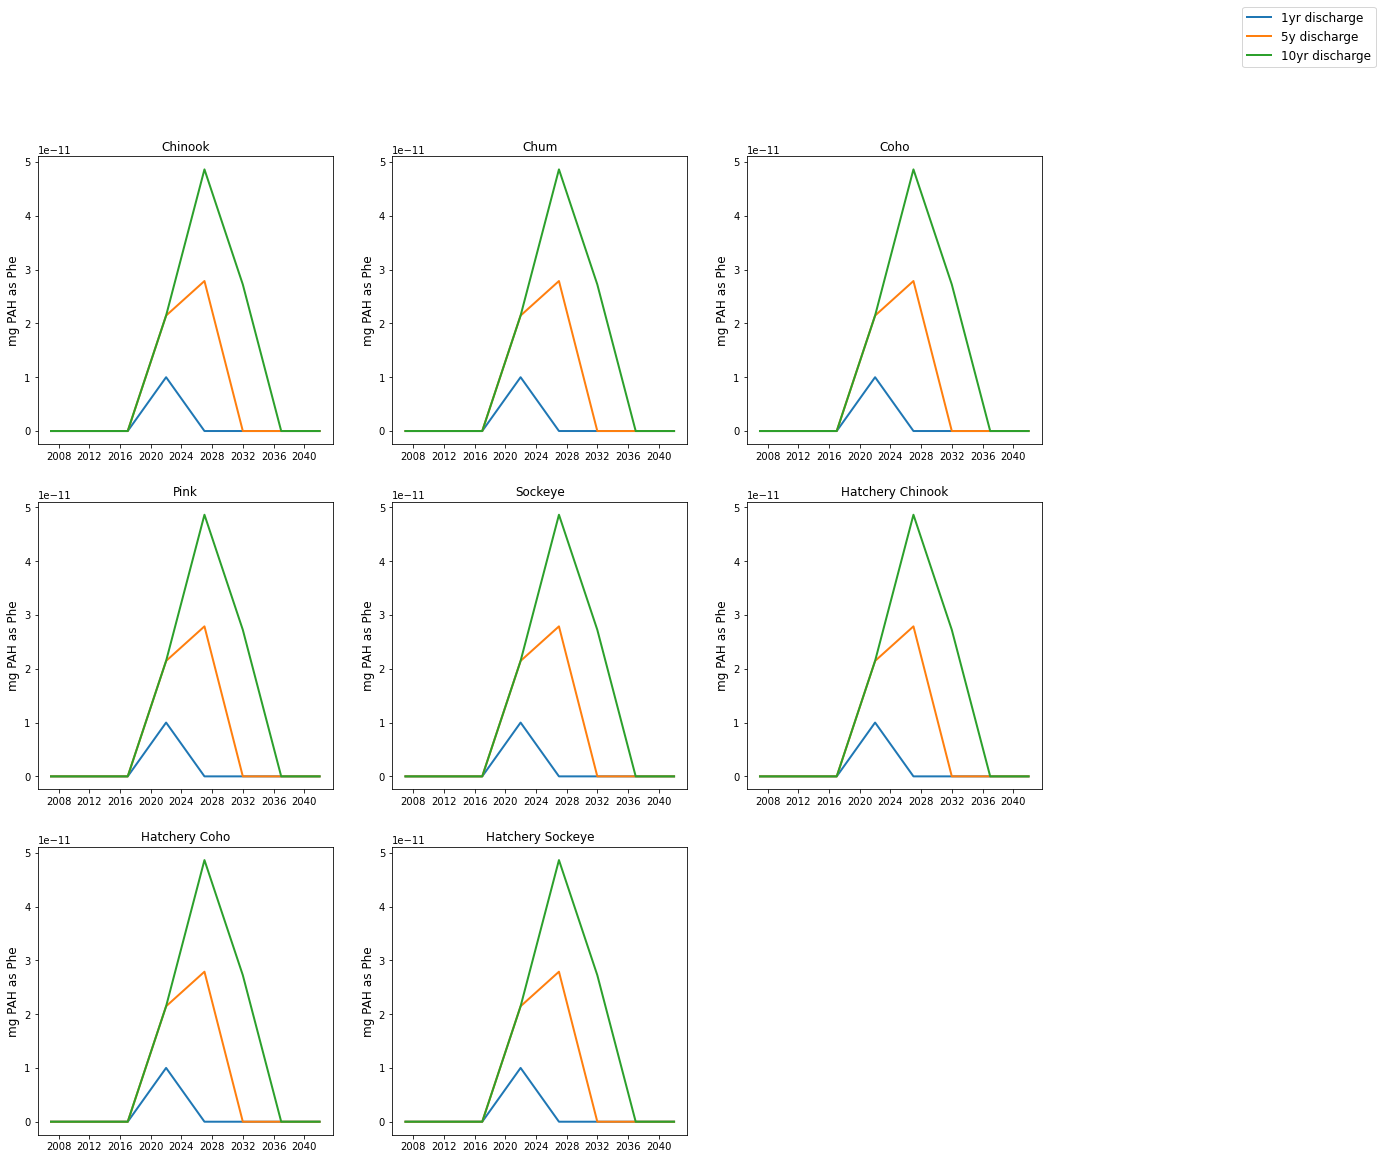

In [39]:
tissue_juveniles_concentration(groups.salmon, annual_scenarios)

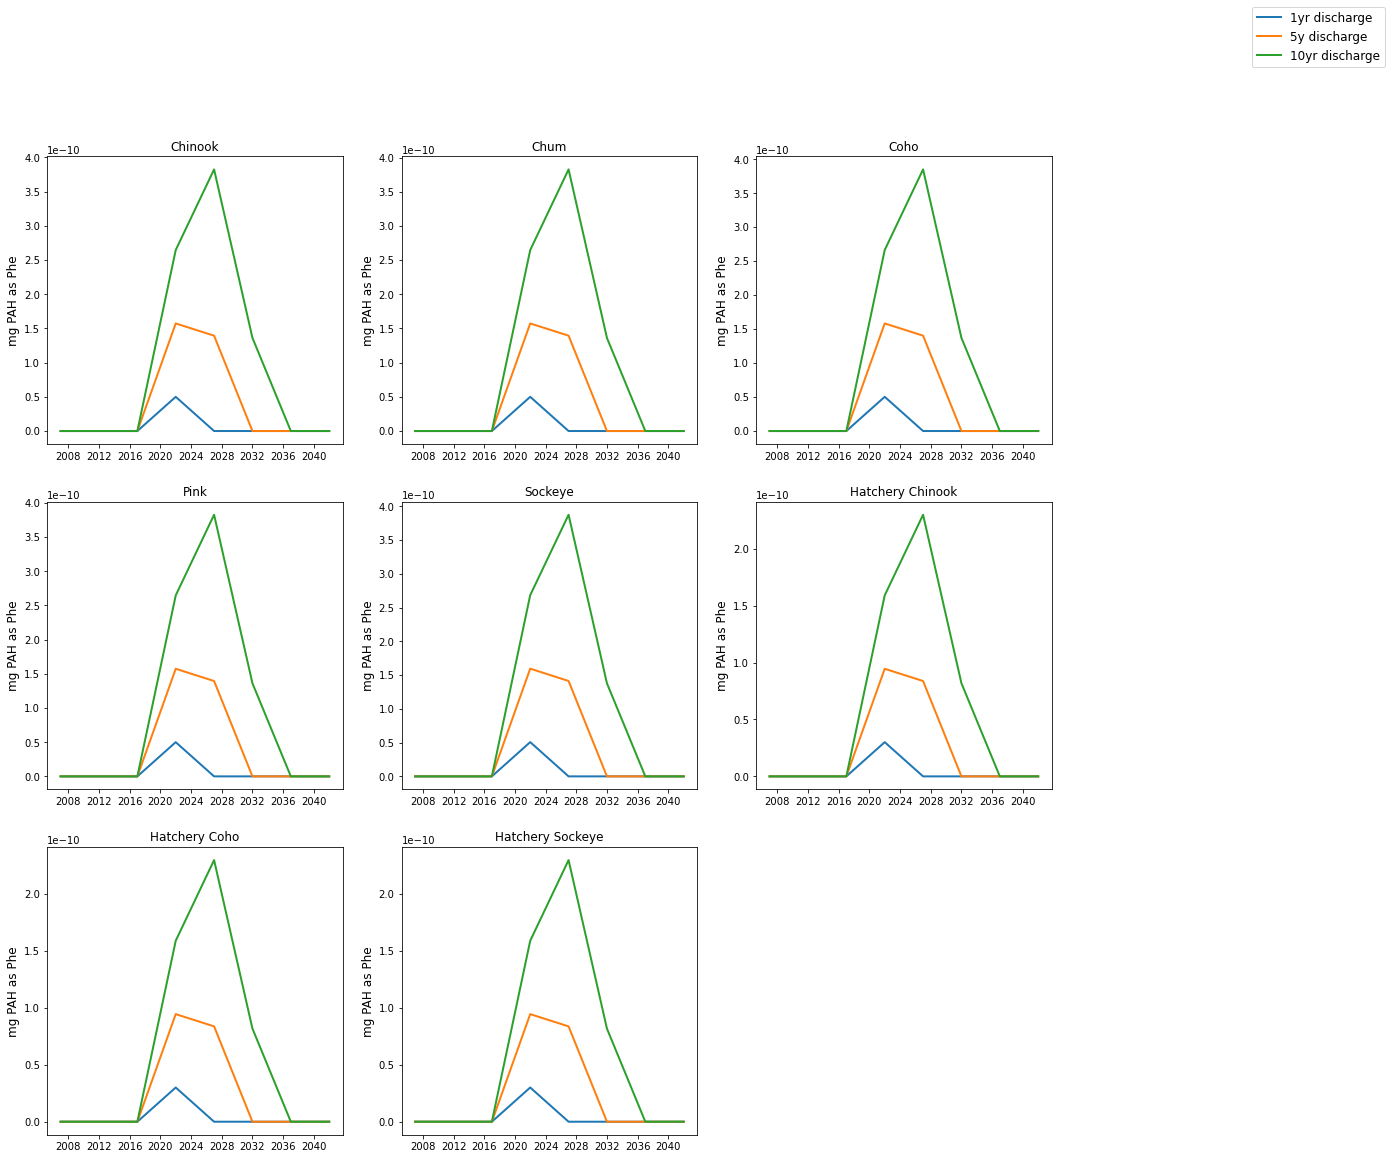

In [42]:
tissue_vertebrate_concentration(groups.salmon, annual_scenarios)

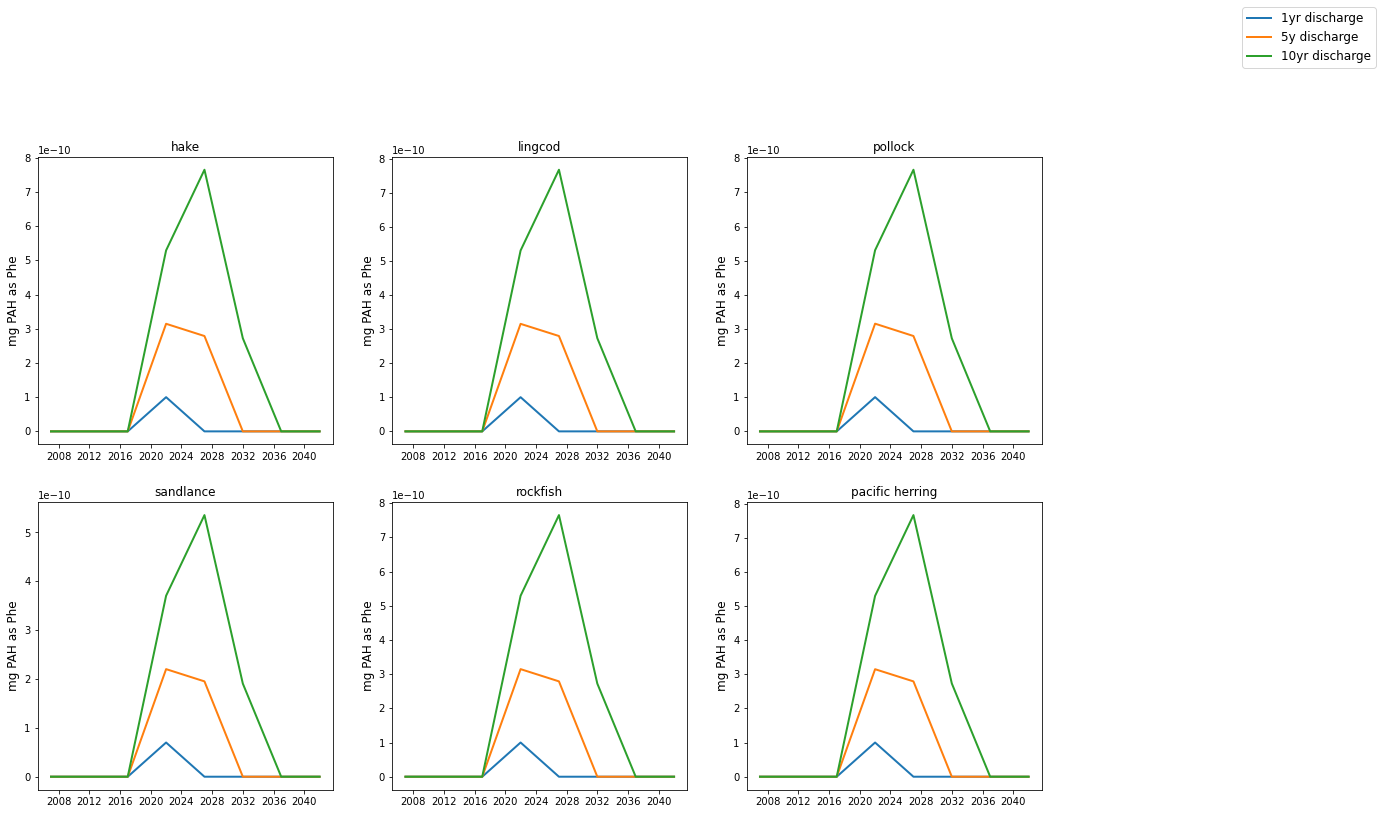

In [43]:
tissue_vertebrate_concentration(groups.named_fish, annual_scenarios)

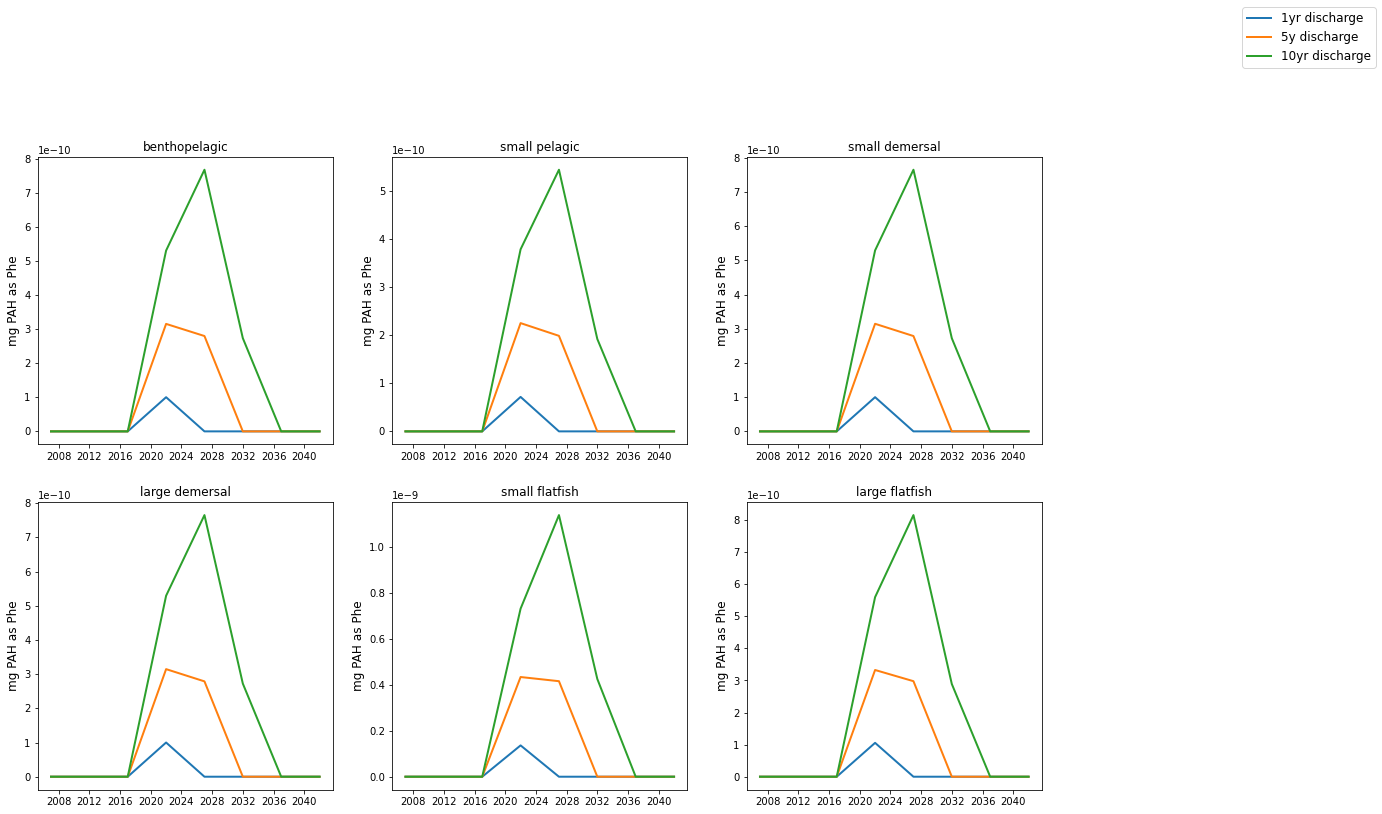

In [44]:
tissue_vertebrate_concentration(groups.other_fish, annual_scenarios)

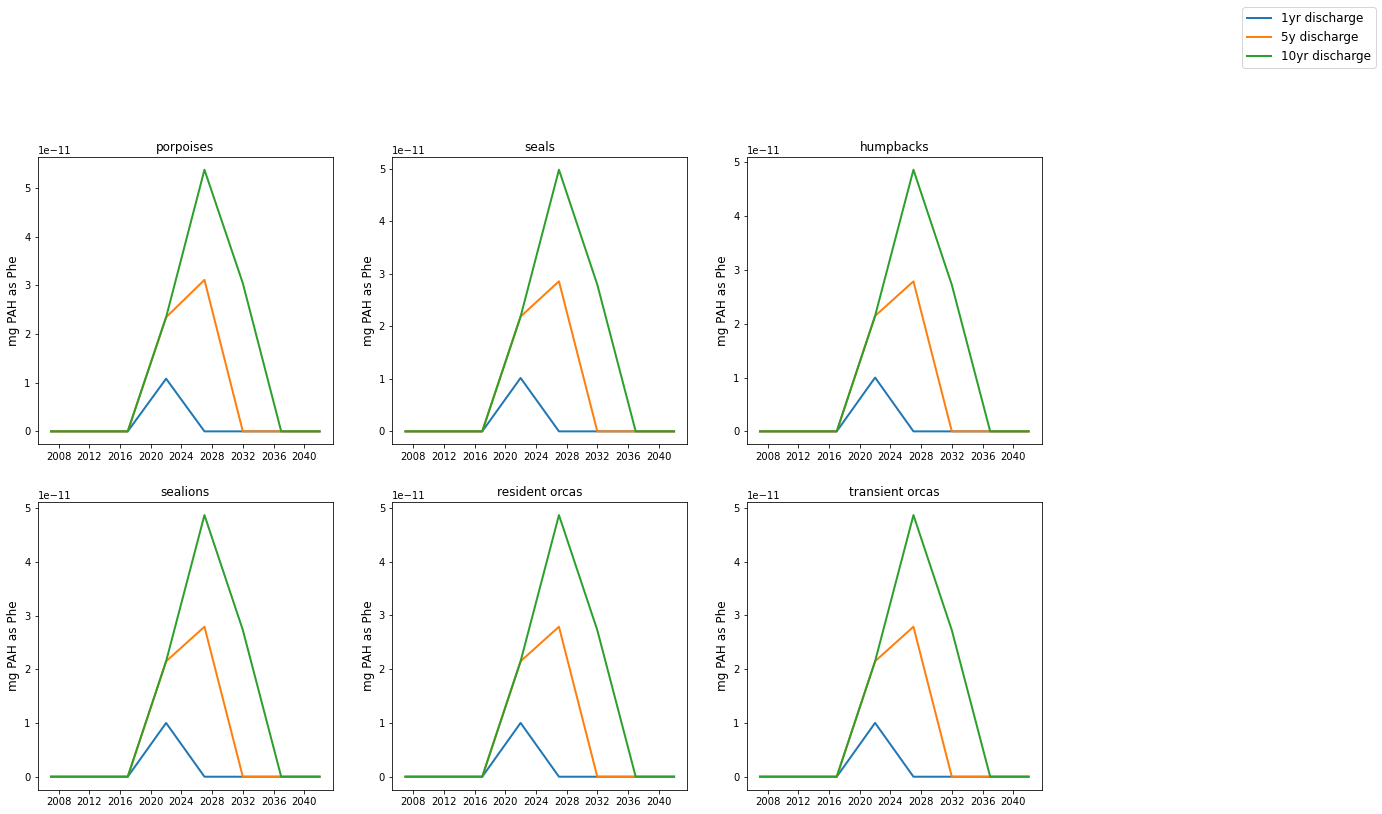

In [45]:
tissue_juveniles_concentration(groups.mammals, annual_scenarios)

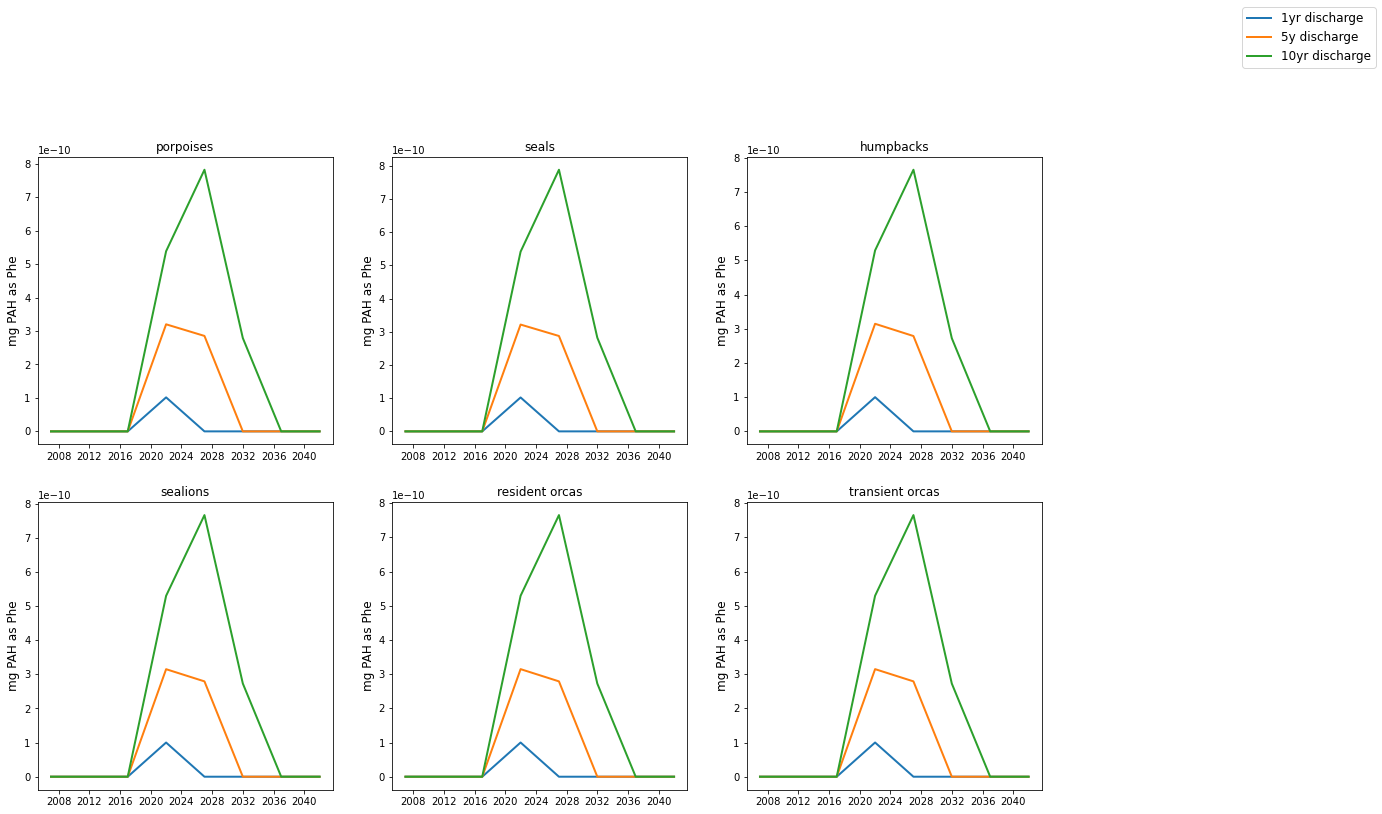

In [46]:
tissue_vertebrate_concentration(groups.mammals, annual_scenarios)

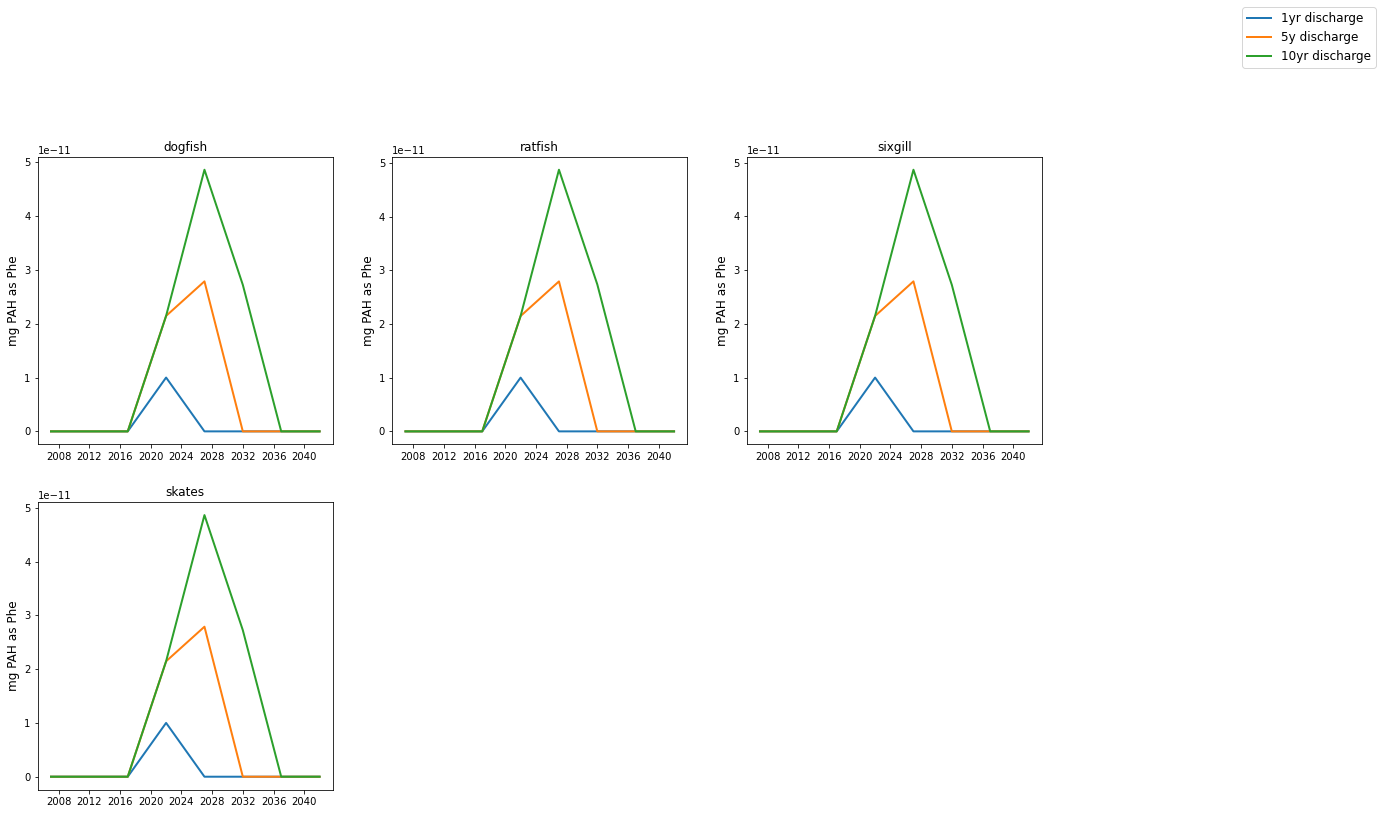

In [47]:
tissue_adults_concentration(groups.sharks, annual_scenarios)

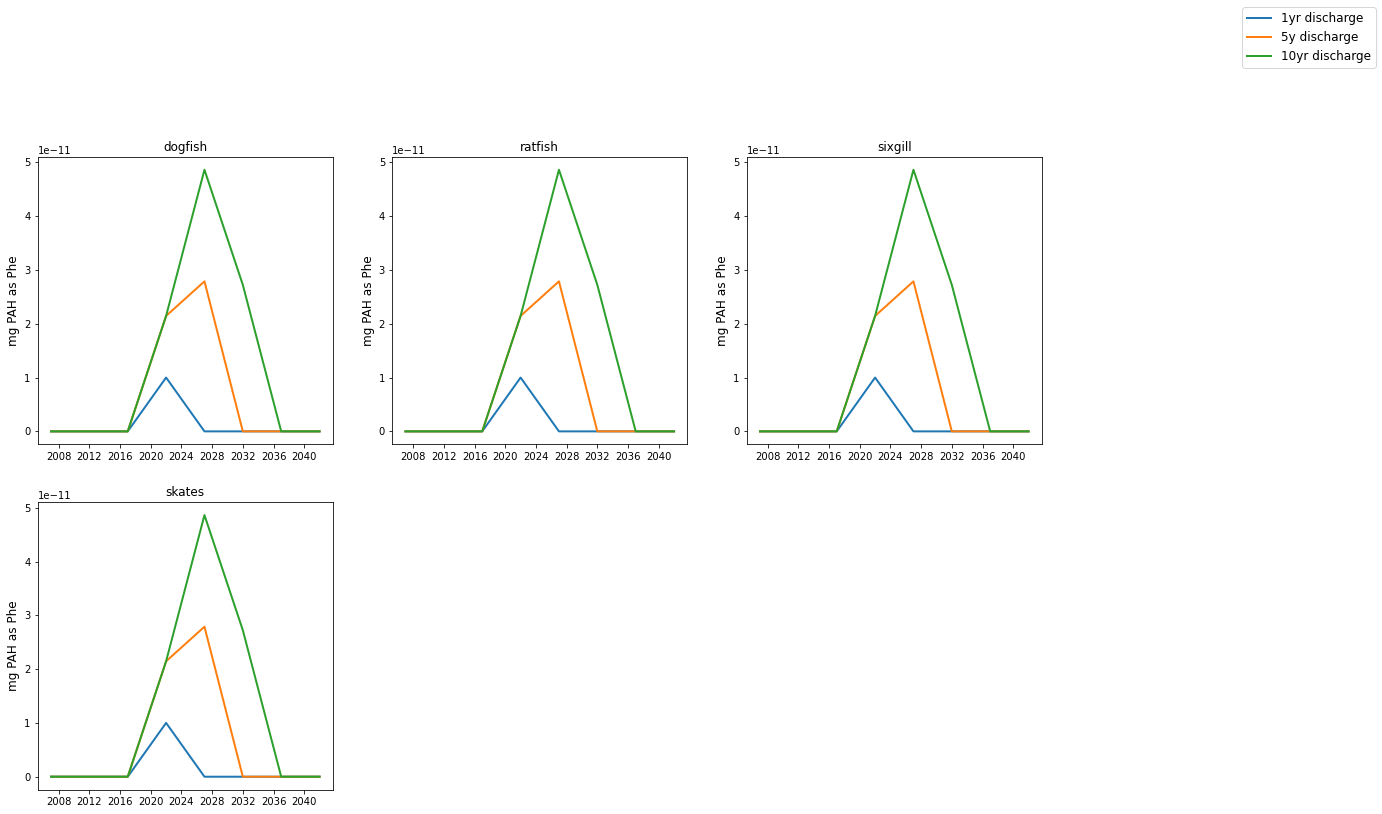

In [49]:
tissue_juveniles_concentration(groups.sharks, annual_scenarios)